In [71]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime as dt


## Data Loading

Dataset from Kaggle HDB flat prices 1990-2021 March
840,000 transactions of HDB resale flats, including address and geolocation

https://www.kaggle.com/datasets/denzilg/hdb-flat-prices-19902021-march?resource=download

We are using the ALL Prices 1990-2021 Mar.csv but we changed the name to HDBData

# META Data

Original columns: month, town, flat_type, block, street_name, storey_range, area_sqm, flat_model, lease_start, resale_price

month: Year and month in YYYY-MM format
year: Year in YYYY format
town: Town according to HDB planning areas (see under categorisation below for all of them). One town (Lim Chu Kang) only has transactions in the early 1990s while Punggol is a very new town without transactions in the early 1990s so you may encounter errors in some scenarios.
town_dummy: dummy variable from 1-6 based on my categorisation of towns from most to least prime. These are subjective, not objective so if you disagree with my categorisation and/or want to use your own then go ahead!
Categorisation:
north=['SEMBAWANG','YISHUN','WOODLANDS'] --> 5
northwest=['CHOA CHU KANG','BUKIT BATOK','BUKIT PANJANG','LIM CHU KANG'] --> 6
northeast=['HOUGANG','SENGKANG','PUNGGOL'] --> 4
primecentral=['BISHAN','BUKIT TIMAH', 'CENTRAL AREA'] --> 1
geocentral=['ANG MO KIO','TOA PAYOH','SERANGOON'] --> 2
westcentral=['CLEMENTI','QUEENSTOWN','BUKIT MERAH'] --> 2
eastcentral=['KALLANG/WHAMPOA', 'MARINE PARADE','GEYLANG'] --> 3
fareast=['BEDOK','PASIR RIS','TAMPINES'] --> 4
farwest=['JURONG EAST', 'JURONG WEST'] --> 5
flat_type: HDB-specified flat type ['4 ROOM' '3 ROOM' '1 ROOM' '5 ROOM' 'EXECUTIVE' '2 ROOM'
'MULTI GENERATION']
block: Block number (NOT flat number) of the HDB block
street_name: Street name of the HDB block
address: Identifying address formed by concatenating block+street_name+"SINGAPORE". No postal code unfortunately but I may try to add it in the future.
latitude: Latitude coordinate of the HDB block, mostly between 1.27-1.46
longitude: Longitude coordinate of the HDB block, mostly between 103.5-104.0
storey_range: 3-number ranges (e.g. 1 TO 3, 19 TO 21) that contain the actual storey number (HDB doesn't reveal the exact floor)
storey: Middle number in the storey range, useful as a numerical approximation that can be used for data visualisation/machine learning
area_sqm: Size of the flat in square metres
flat_model: HDB-specified flat model (not the same as flat type) ['New Generation', 'Improved', 'Standard', 'Model A', 'Apartment', 'Maisonette', 'Model A-Maisonette', 'Simplified', 'Terrace', 'Improved-Maisonette', 'MULTI GENERATION', 'Premium Apartment', 'Multi Generation', 'Adjoined flat', 'Premium Maisonette', '2-room', 'Model A2', 'DBSS', 'Type S1', 'Type S2', 'Premium Apartment Loft']
lease_start: Year in which the 99-year lease commenced.
lease_rem: The number of years of remaining lease, as calcualted from 2021-lease_start. For a few anomalies, the year of transaction is BEFORE the year of lease starting which is strange but could be due to house flipping before the Minimum Occupancy Period was introduced?
resale_price: The agreed transaction price in nominal S$ of the house, excluding stamp duties and other agent fees
price_psm: The price per square metre as calculated from resale_price/area_sqm
price_psm_yearly: The "yearly" price per square metre as calculated from price_psm/lease_rem --> removed in Version 2
Core CPI: The core CPI index value at the month of the transaction, based on the data by MAS
price cpi_adj: The real, inflation-adjusted resale price of the flat, calculated using (resale_price/Core CPI)*100
price_psm cpi_adj: The real, inflation-adjusted price per square metre of the flat, which is the best indicator of how expensive the flat is. Calculated using (price_psm/Core CPI)*100
bala lease pct: The HDB's land value percentage of freehold land value, referencing Bala's Table. Important to consider because when the 99-year lease expires, the HDBs technically have 0 value. Adjusting for the lease remaining in the same way as inflation-adjusting, you can consider the price that is implied if the flat were to have a full 99-year lease.
price lease_adj implied: The resale price implied if the flat were to have a full 99-year lease, calculated from (resale_price/bala lease pct)*96
price_psm lease_adj implied: The price per square metre implied if the flat were to have a full 99-year lease, calculated from (price_psm/bala lease pct)*96
price cpi_lease_adj implied: The inflation-adjusted resale price implied if the flat were to have a full 99-year lease, calculated from (price cpi_adj/bala lease pct)*96
price_psm cpi_lease_adj implied: The inflation-adjusted price per square metre implied if the flat were to have a full 99-year lease, calculated from (price_psm cpi_adj/bala lease pct)*96
year_gni: Singapore's GNI per capita (nominal S$) in the year of the transaction



In [72]:
HDBData = pd.read_csv('HDBPrice.csv')
HDBData.head()

,month,year,town,town_dummy,flat_type,block,street_name,address,latitude,longitude,...,price_psm_yearly,Core CPI,price_cpi_adj,price_psm_cpi_adj,bala_lease_pct,price_lease_adj_implied,price_psm_lease_adj_implied,price_cpi_lease_adj_implied,price_psm_cpi_lease_adj_implied,year_gni
0,1990-01,1990,ANG MO KIO,2,4 ROOM,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,10.997442,61.59,139633.05730,1517.750623,92.9,88869.75242,965.975570,144292.50270,1568.396769,22901
1,1990-01,1990,ANG MO KIO,2,3 ROOM,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,8.464849,61.59,95794.77188,1168.228925,92.9,60968.78364,743.521752,98991.36814,1207.211806,22901
2,1990-01,1990,ANG MO KIO,2,3 ROOM,216,ANG MO KIO AVE 1,216 ANG MO KIO AVE 1 SINGAPORE,1.366272,103.841465,...,7.606769,61.59,76635.81750,1049.805719,92.9,48775.02691,668.151054,79193.09451,1084.836911,22901
3,1990-01,1990,ANG MO KIO,2,3 ROOM,308,ANG MO KIO AVE 1,308 ANG MO KIO AVE 1 SINGAPORE,1.365485,103.844025,...,8.287972,61.59,76635.81750,1143.818172,92.9,48775.02691,727.985476,79193.09451,1181.986486,22901
4,1990-01,1990,ANG MO KIO,2,4 ROOM,211,ANG MO KIO AVE 3,211 ANG MO KIO AVE 3 SINGAPORE,1.369226,103.841652,...,11.484353,61.59,129891.21610,1603.595261,93.3,82315.11254,1016.235957,133650.12590,1650.001555,22901


In [73]:
HDBData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840918 entries, 0 to 840917
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   month                            840918 non-null  object 
 1   year                             840918 non-null  int64  
 2   town                             840918 non-null  object 
 3   town_dummy                       840918 non-null  int64  
 4   flat_type                        840918 non-null  object 
 5   block                            840918 non-null  object 
 6   street_name                      840918 non-null  object 
 7   address                          840918 non-null  object 
 8   latitude                         840918 non-null  float64
 9   longitude                        840918 non-null  float64
 10  storey_range                     840918 non-null  object 
 11  storey                           840918 non-null  int64  
 12  ar

In [74]:
HDBData['flat_type'].unique()

array(['4 ROOM', '3 ROOM', '1 ROOM', '5 ROOM', 'EXECUTIVE', '2 ROOM',
       'MULTI GENERATION'], dtype=object)

In [75]:
HDBData['flat_type'].value_counts()

4 ROOM              315272
3 ROOM              275698
5 ROOM              174260
EXECUTIVE            63838
2 ROOM               10059
1 ROOM                1280
MULTI GENERATION       511
Name: flat_type, dtype: int64

## Data Cleaning

We dont have any NULL data in our dataset. The only thing we did for data cleaning is replacing some of the duplicate value of flat model. 

In [76]:
HDBData['month'] = pd.to_datetime(HDBData['month']) # to datetime

In [77]:
HDBData['flat_model'].value_counts()

Model A                   233098
Improved                  221001
New Generation            179236
Simplified                 54422
Standard                   40278
Premium Apartment          36776
Apartment                  32596
Maisonette                 27388
Model A2                    9232
DBSS                        1957
Model A-Maisonette          1921
Adjoined flat               1112
Terrace                      652
Type S1                      293
MULTI GENERATION             279
Multi Generation             232
Type S2                      146
Improved-Maisonette          116
Premium Maisonette            83
Premium Apartment Loft        57
2-room                        22
2-ROOM                        21
Name: flat_model, dtype: int64

In [78]:
# Rename flat model duplicates
replace_values = {'MULTI GENERATION':'Multi Generation', 'Improved-Maisonette':'Executive Maisonette', 'Premium Maisonette':'Executive Maisonette', '2-ROOM':'2-room', 'Model A-Maisonette':'Maisonette', 'Premium Apartment Loft':'Premium Apartment', 'Type S1':'Type S1S2', 'Type S2':'Type S1S2'}

HDBData = HDBData.replace({'flat_model': replace_values})

HDBData['flat_model'].value_counts()


Model A                 233098
Improved                221001
New Generation          179236
Simplified               54422
Standard                 40278
Premium Apartment        36833
Apartment                32596
Maisonette               29309
Model A2                  9232
DBSS                      1957
Adjoined flat             1112
Terrace                    652
Multi Generation           511
Type S1S2                  439
Executive Maisonette       199
2-room                      43
Name: flat_model, dtype: int64

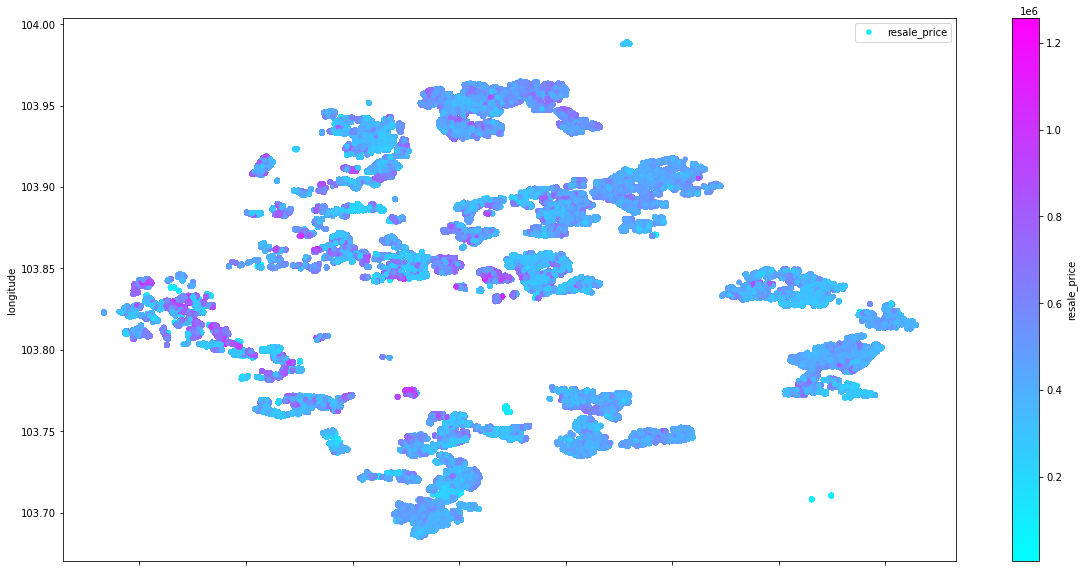

In [79]:
HDBData.plot(kind='scatter', 
                x = 'latitude', 
                y= 'longitude', 
                c ='resale_price', 
                label= 'resale_price', 
                cmap = 'cool',
                colorbar = True,
                figsize = (20,10))
plt.show()

## Exploratory Data Analysis



## Analysis of Non-Categorical Variable

In [80]:
HDBSub = pd.DataFrame(HDBData[['year','area_sqm','lease_rem','resale_price','year_gni']])
HDBSub.head()

,year,area_sqm,lease_rem,resale_price,year_gni
0,1990,92.0,85,86000.0,22901
1,1990,82.0,85,59000.0,22901
2,1990,73.0,85,47200.0,22901
3,1990,67.0,85,47200.0,22901
4,1990,81.0,86,80000.0,22901


In [81]:
HDBSub.describe()

,year,area_sqm,lease_rem,resale_price,year_gni
count,840918.000000,840918.000000,840918.000000,8.409180e+05,840918.000000
mean,2004.512196,95.608704,81.780300,2.968002e+05,49518.956025
std,8.135802,26.026266,9.959341,1.509764e+05,15844.785659
min,1990.000000,28.000000,45.000000,5.000000e+03,22901.000000
25%,1998.000000,73.000000,75.000000,1.830000e+05,37363.000000
50%,2003.000000,93.000000,83.000000,2.780000e+05,40870.000000
75%,2010.000000,114.000000,90.000000,3.870000e+05,63712.000000
max,2021.000000,307.000000,101.000000,1.258000e+06,79517.000000


<AxesSubplot:xlabel='year', ylabel='resale_price'>

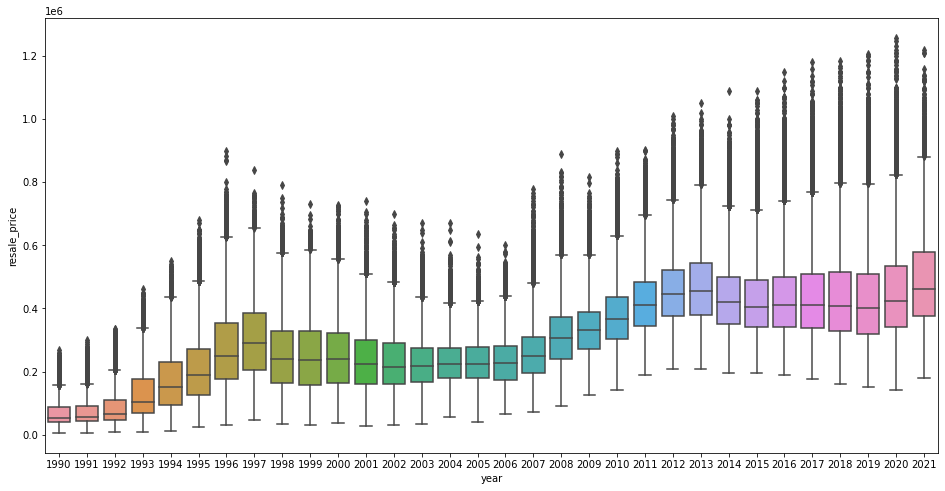

In [82]:
fig, axes = plt.subplots(figsize = (16, 8))  #Distribution of Life Ladder of all countries in the data for given years
sb.boxplot(x="year", y="resale_price",  data=HDBData, ax = axes)   #shown throught boxplot

C:\Users\zhenx\AppData\Local\Temp/ipykernel_2364/1107863208.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(xlabels)


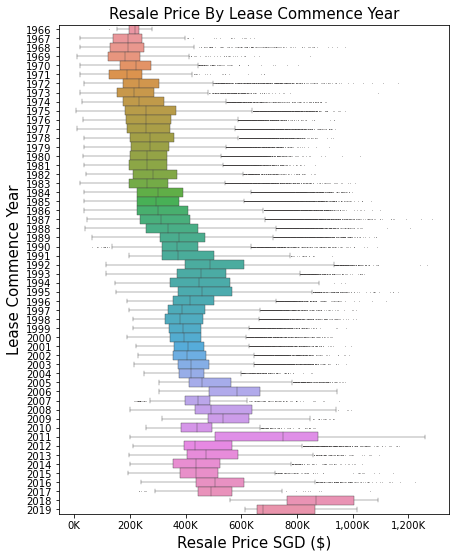

In [116]:
# Boxplot for each year of lease commence date

fig = plt.figure(figsize=(7,9)) 
p=sb.boxplot(y='lease_start', x='real_price', data=HDBData, width=1, orient='h', flierprops = dict(markerfacecolor = 'red', markersize = 0.1, linestyle='none'), linewidth=0.4)
p.set_xlabel('Resale Price SGD ($)', size=15), p.set_ylabel('Lease Commence Year', size=15)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_xticks()/1000]
p.set_xticklabels(xlabels)
p.set_title('Resale Price By Lease Commence Year', size=15)
plt.show()

In [83]:
print(HDBSub.corr())

                  year  area_sqm  lease_rem  resale_price  year_gni
year          1.000000  0.072732  -0.448049      0.612810  0.974423
area_sqm      0.072732  1.000000   0.379417      0.618914  0.065983
lease_rem    -0.448049  0.379417   1.000000     -0.013812 -0.449205
resale_price  0.612810  0.618914  -0.013812      1.000000  0.631369
year_gni      0.974423  0.065983  -0.449205      0.631369  1.000000


<AxesSubplot:>

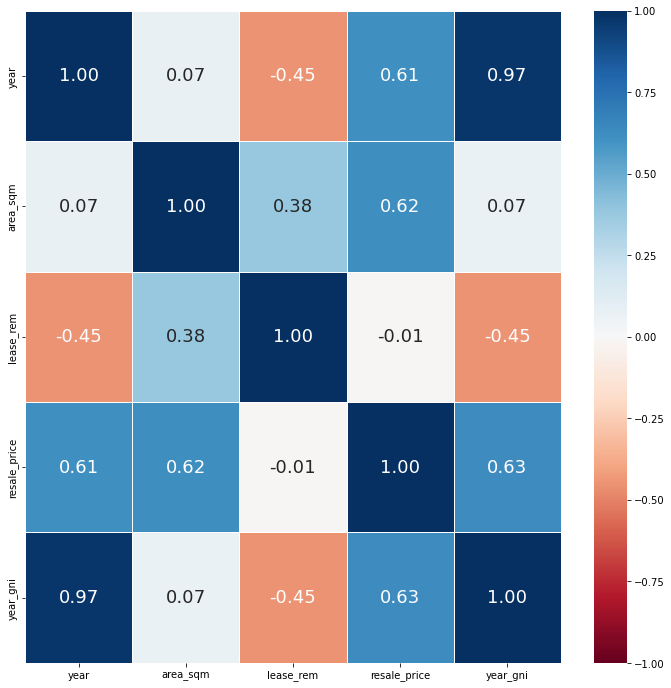

In [84]:
# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(12, 12))
sb.heatmap(HDBSub.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We Were very surprice to find out lease_rem have no impact on the resale price. I guess since the average lease remaining is still around 81 years which is a very long time hence it wasnt that big of a factor.

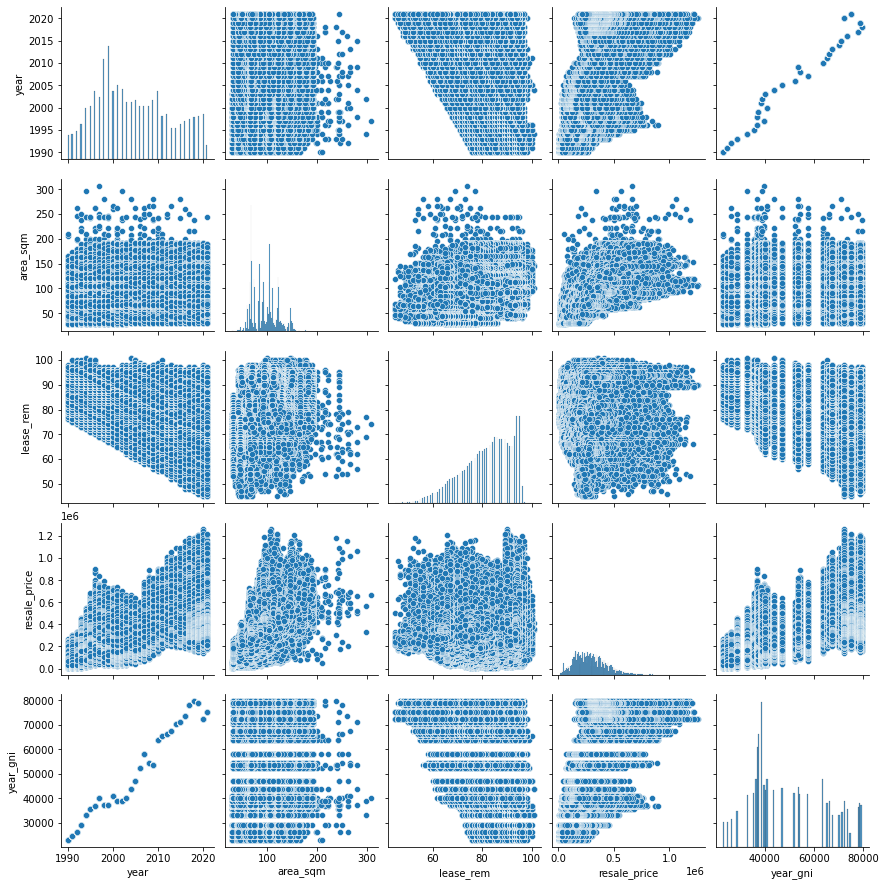

In [85]:
sb.pairplot(data = HDBSub)

## Analysis of Categorical variable 

We picked the Town, Storey, Flat Model, Flat Type as potential categorical variable that will impact the resale price. 

In [86]:
HDBCat = pd.DataFrame(HDBData[['town','storey','flat_model','flat_type']])
HDBCat.head()

,town,storey,flat_model,flat_type
0,ANG MO KIO,11,New Generation,4 ROOM
1,ANG MO KIO,8,New Generation,3 ROOM
2,ANG MO KIO,5,New Generation,3 ROOM
3,ANG MO KIO,11,New Generation,3 ROOM
4,ANG MO KIO,5,New Generation,4 ROOM


In [87]:
HDBCat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840918 entries, 0 to 840917
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   town        840918 non-null  object
 1   storey      840918 non-null  int64 
 2   flat_model  840918 non-null  object
 3   flat_type   840918 non-null  object
dtypes: int64(1), object(3)
memory usage: 25.7+ MB


In [88]:
#Convert into category
HDBCat = HDBCat.astype('category')

In [89]:
HDBCat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840918 entries, 0 to 840917
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   town        840918 non-null  category
 1   storey      840918 non-null  category
 2   flat_model  840918 non-null  category
 3   flat_type   840918 non-null  category
dtypes: category(4)
memory usage: 3.2 MB


In [90]:
HDBCat.describe()

,town,storey,flat_model,flat_type
count,840918,840918,840918,840918
unique,27,22,16,7
top,TAMPINES,5,Model A,4 ROOM
freq,74167,213008,233098,315272


In [91]:
HDBCat["town"].nunique()

27

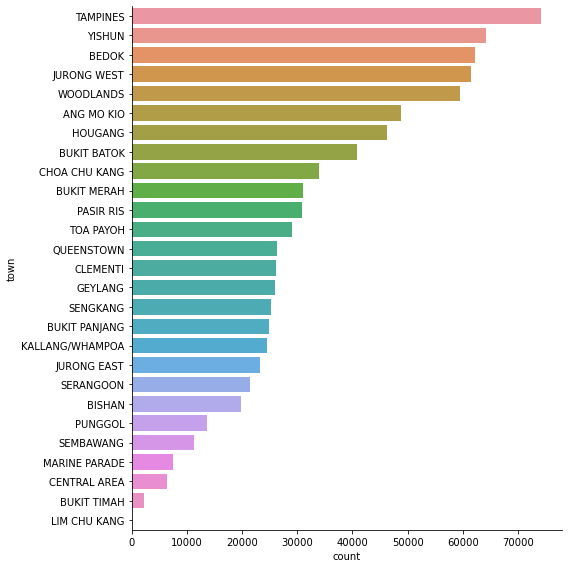

In [92]:
sb.catplot(y = 'town', data = HDBCat, 
           kind = "count", 
           height = 8, 
           order = HDBCat['town'].value_counts().index)

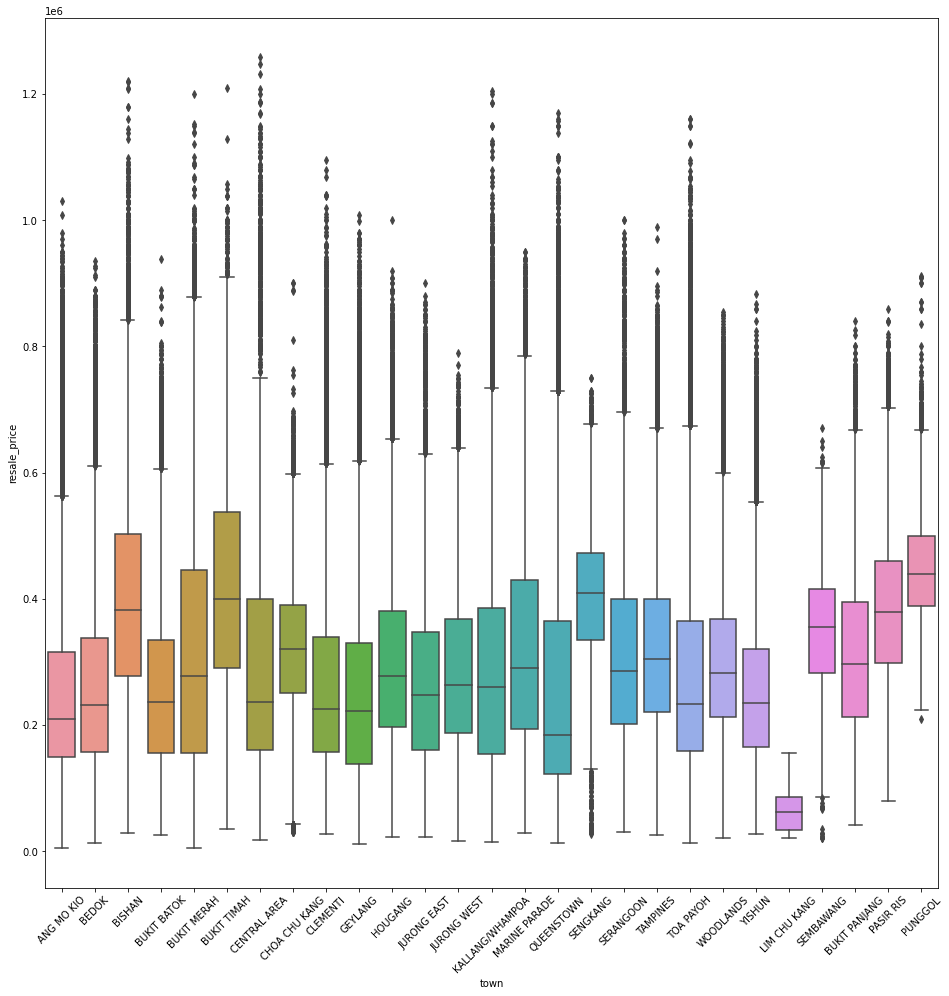

In [93]:
f = plt.figure(figsize=(16,16))
sb.boxplot(x = 'town', y = 'resale_price', data = HDBData)

plt.xticks(rotation=45);

Thoughts: Tampines, Yishun and Bedok having the highest count of flats sold. However the boxplot suggested that the resale price is not driven by demands.
<br>
<br>


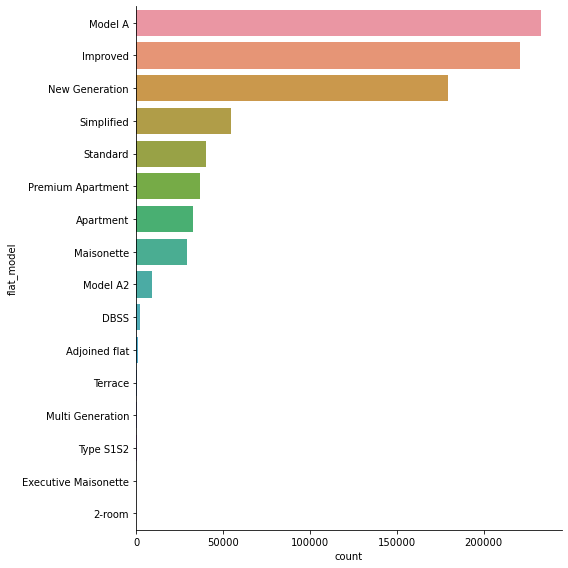

In [94]:
sb.catplot(y = 'flat_model', data = HDBCat, 
           kind = "count", 
           height = 8, 
           order = HDBCat['flat_model'].value_counts().index)

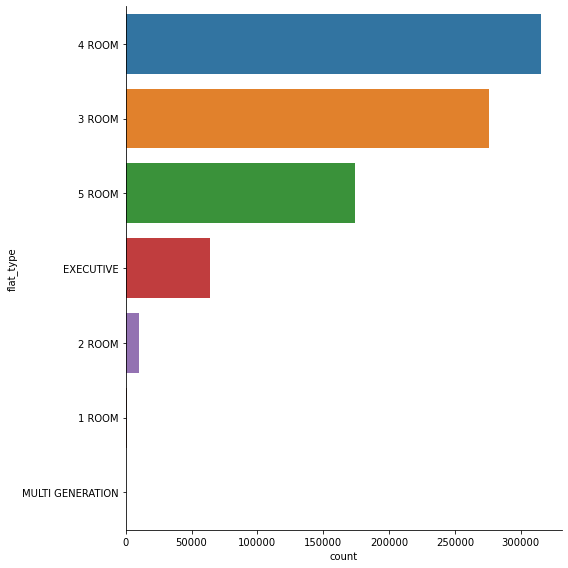

In [95]:
sb.catplot(y = 'flat_type', data = HDBCat, 
           kind = "count", 
           height = 8, 
           order = HDBCat['flat_type'].value_counts().index)

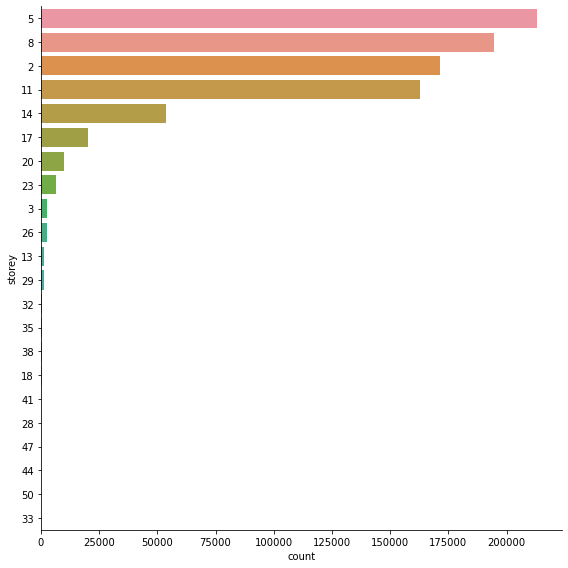

In [97]:
sb.catplot(y = 'storey', data = HDBCat, 
           kind = "count", 
           height = 8, 
           order = HDBCat['storey'].value_counts().index)

<b>Note: The storey is the middle number of the storey range and not the actual storey itself.<b/>

In [98]:
HDBCat = pd.concat([HDBCat, HDBData["resale_price"]], axis = 1).reindex(HDBCat.index)
HDBCat.head()

,town,storey,flat_model,flat_type,resale_price
0,ANG MO KIO,11,New Generation,4 ROOM,86000.0
1,ANG MO KIO,8,New Generation,3 ROOM,59000.0
2,ANG MO KIO,5,New Generation,3 ROOM,47200.0
3,ANG MO KIO,11,New Generation,3 ROOM,47200.0
4,ANG MO KIO,5,New Generation,4 ROOM,80000.0


{'4 ROOM': 37.49140819913476, '3 ROOM': 32.785360760502215, '5 ROOM': 20.722591263357426, 'EXECUTIVE': 7.59146551744641, '2 ROOM': 1.1961927322283505, '1 ROOM': 0.15221460356420008, 'MULTI GENERATION': 0.0607669237666455}
{'4 ROOM': 41.414575776838795, '5 ROOM': 24.760685039075646, '3 ROOM': 24.318513255805257, 'EXECUTIVE': 7.983397524585873, '2 ROOM': 1.4396290618105674, 'MULTI GENERATION': 0.04206708297498411, '1 ROOM': 0.04113225890887335}


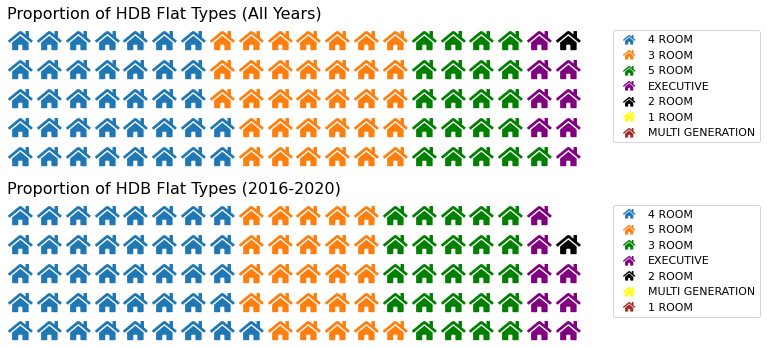

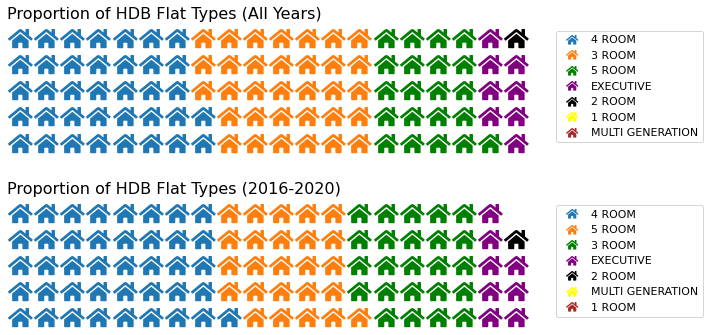

In [99]:
## Waffle chart for flat type - number of rooms

from pywaffle import  Waffle

flattype = dict(HDBData['flat_type'].value_counts()/len(HDBData)*100)
print(flattype)


flattype1620 = dict(HDBData.set_index('month')['2016':'2020'].reset_index()['flat_type'].value_counts()/len(HDBData.set_index('month')['2016':'2020'].reset_index())*100)
print(flattype1620)
plt.figure(figsize=(10,5),
    FigureClass=Waffle, 
    plots={
        211: {
            'values': flattype,
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':11},
            'title': {'label': 'Proportion of HDB Flat Types (All Years)', 'loc': 'left', 'fontsize':16}
        },
        212: {
            'values': flattype1620,
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':11},
            'title': {'label': 'Proportion of HDB Flat Types (2016-2020)', 'loc': 'left', 'fontsize':16}            
        },
    },
    rows=5, 
    colors=["#1f77b4", "#ff7f0e", "green", 'purple', 'black', 'yellow', 'brown'],
    #colors=["#3c78d8", "#00cef6", "#aff000", '#28324a', 'black', 'yellow', 'brown'],
    icons='home', 
    font_size=22, 
    icon_legend=True)
    
# plt.show()

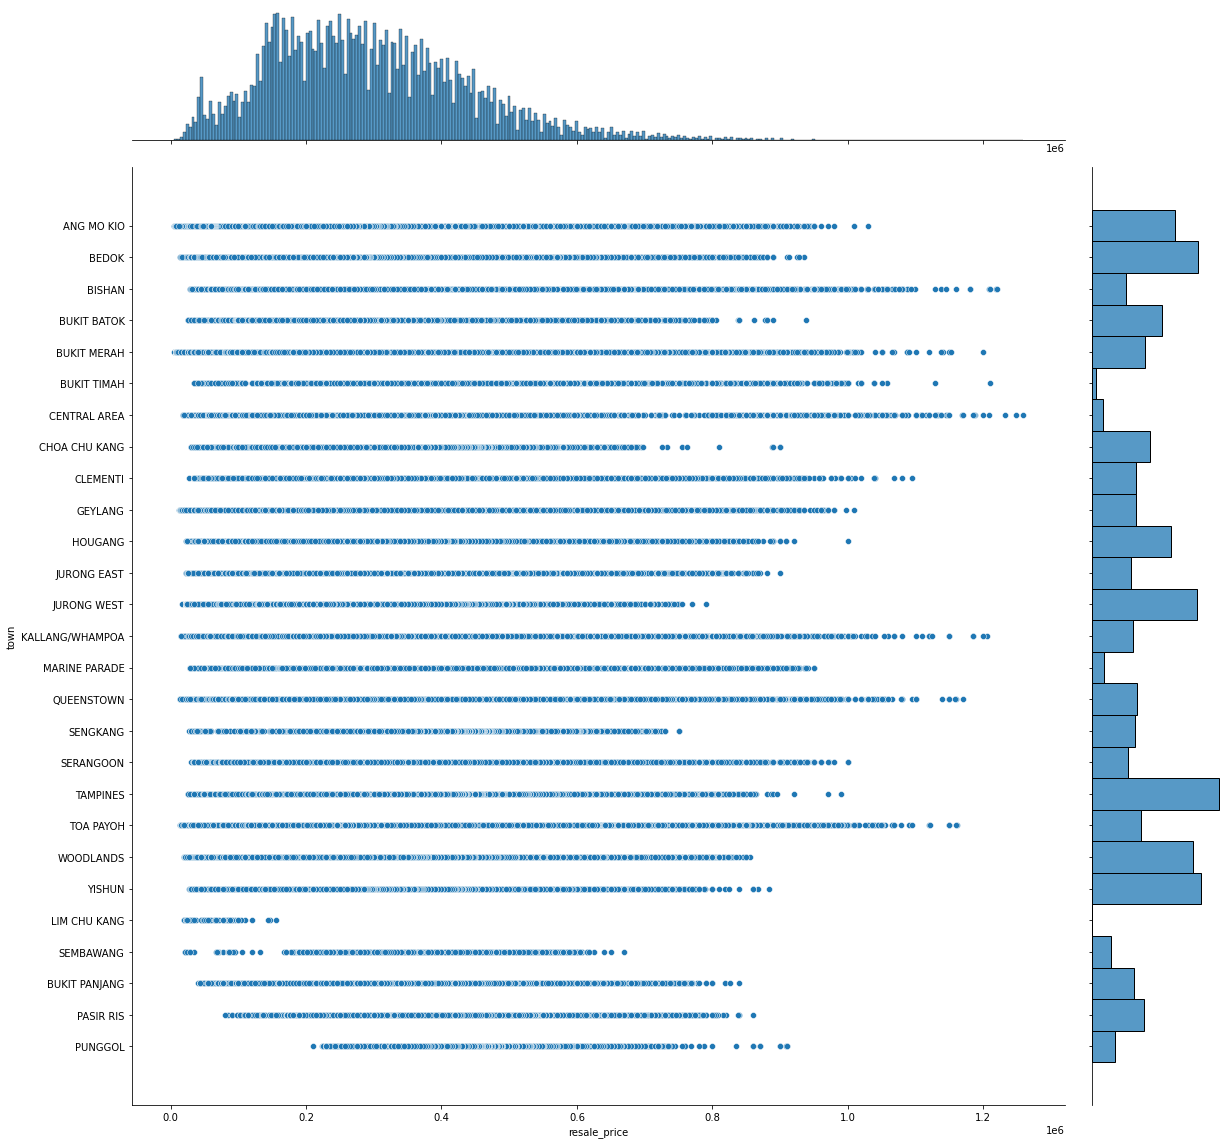

In [100]:
sb.jointplot(x = "resale_price", y = "town", height=16, ratio=6, data = HDBData)


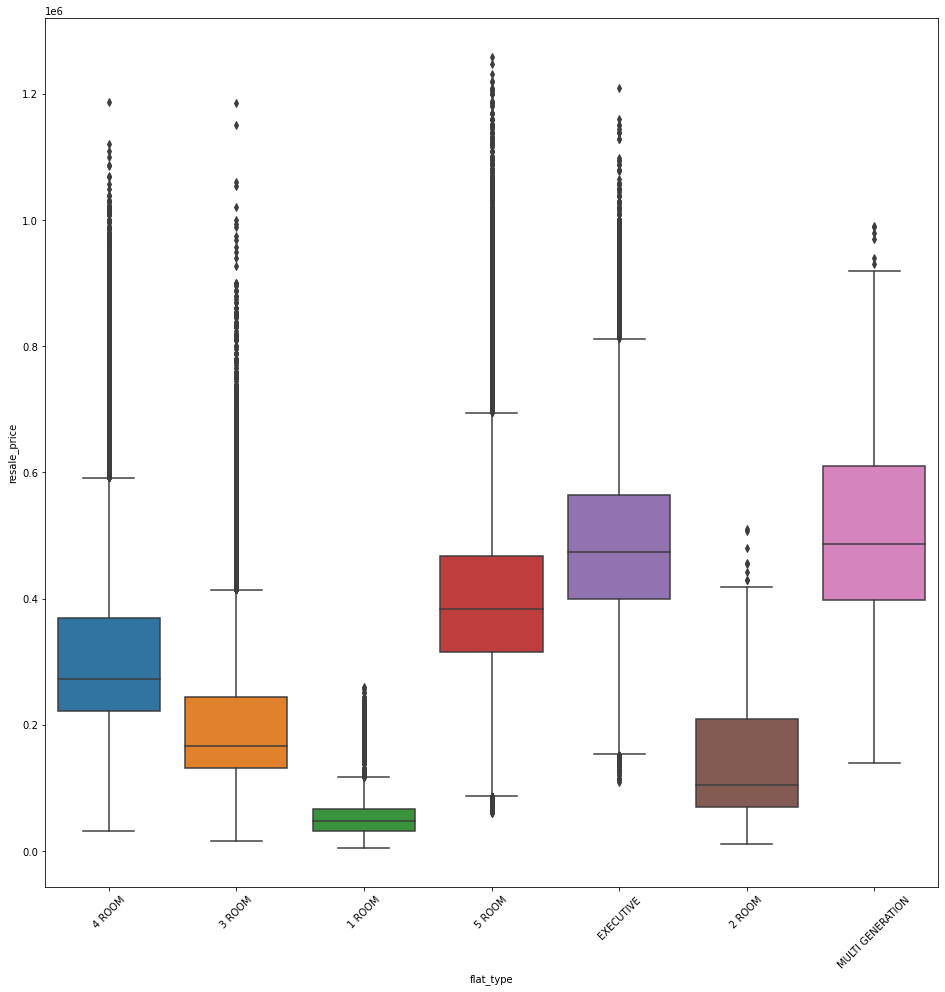

In [101]:
f = plt.figure(figsize=(16,16))
sb.boxplot(x = 'flat_type', y = 'resale_price', data = HDBData)

plt.xticks(rotation=45);

In [102]:
# Compute Resale Price Adjusted for Inflation Using Consumer Price Index for Housing & Utilities
# https://www.singstat.gov.sg/find-data/search-by-theme/economy/prices-and-price-indices/latest-data
cpi = pd.read_csv('CPI.csv')
cpi.head()

,month,cpi
0,1961 Jan,26.553
1,1961 Feb,26.669
2,1961 Mar,26.553
3,1961 Apr,26.650
4,1961 May,26.728


In [103]:
cpi['month'] = pd.to_datetime(cpi['month'], format='%Y %b') # to datetime
HDBData = HDBData.merge(cpi, on='month', how='left') 
# https://people.duke.edu/~rnau/411infla.htm
HDBData['real_price'] = (HDBData['resale_price'] / HDBData['cpi']) * 100 

## Linear Regression

Based on EDA performed above, Year, Year GNI & Area Square per Metre have the highest correlation with resale price. We decided to perform in depth linear regression using these 3 data to predict resale price. 

C:\Users\zhenx\AppData\Local\Temp/ipykernel_2364/718104174.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ylabels)
C:\Users\zhenx\AppData\Local\Temp/ipykernel_2364/718104174.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(pd.Series(['']).append(storey.iloc[[0,5,10,15,20,24],0]))
C:\Users\zhenx\AppData\Local\Temp/ipykernel_2364/718104174.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ylabels); ax2.set_ylabel('')


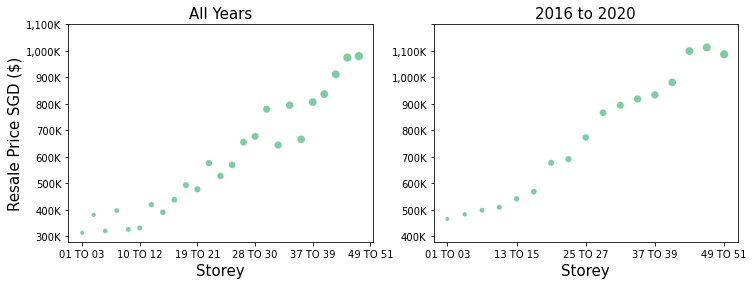

In [104]:
fig = plt.figure(figsize=(12,4))

# Storey Prices
ax1 = plt.subplot(121)
storey = HDBData.groupby('storey_range')['real_price'].median().reset_index().sort_values(by='storey_range')
storey['storey_rank'] = storey['storey_range'].astype('category').cat.codes # label encode
a=sb.scatterplot(x=storey['storey_rank'], y=storey['real_price'], size=storey['storey_rank'].astype('int')*30, color='#00994d', edgecolors='w', alpha=0.5, legend=False, ax=ax1)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in a.get_yticks()/1000]
ax1.set_yticklabels(ylabels)
ax1.set_xticklabels(pd.Series(['']).append(storey.iloc[[0,5,10,15,20,24],0]))
ax1.set_ylim([280000,1100000]), ax1.set_ylabel('Resale Price SGD ($)', size=15), ax1.set_xlabel('Storey', size=15)
ax1.set_title('All Years', size=15)

# Floor Area Prices
ax2 = plt.subplot(122)
storey2 = HDBData[HDBData['year'].isin([2016,2017,2018,2019,2020])].groupby('storey_range')['real_price'].median().reset_index().sort_values(by='storey_range')
storey2['storey_rank'] = storey2['storey_range'].astype('category').cat.codes

# Bubble chart
b=sb.scatterplot(x=storey2['storey_rank'], y=storey2['real_price'], size=storey2['storey_rank'].astype('int')*30, color='#00994d', edgecolors='w', alpha=0.5, legend=False, ax=ax2)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000]
ax2.set_yticklabels(ylabels); ax2.set_ylabel('')
ax2.set_xticks([0,4,8,12,16])
ax2.set_xticklabels(storey2.iloc[[0,4,8,12,16],0])
ax2.set_ylim([280000,1100000]), ax2.set_xlabel('Storey', size=15)
ax2.set_title('2016 to 2020', size=15)

plt.show()

In [105]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression object
linreg = LinearRegression()

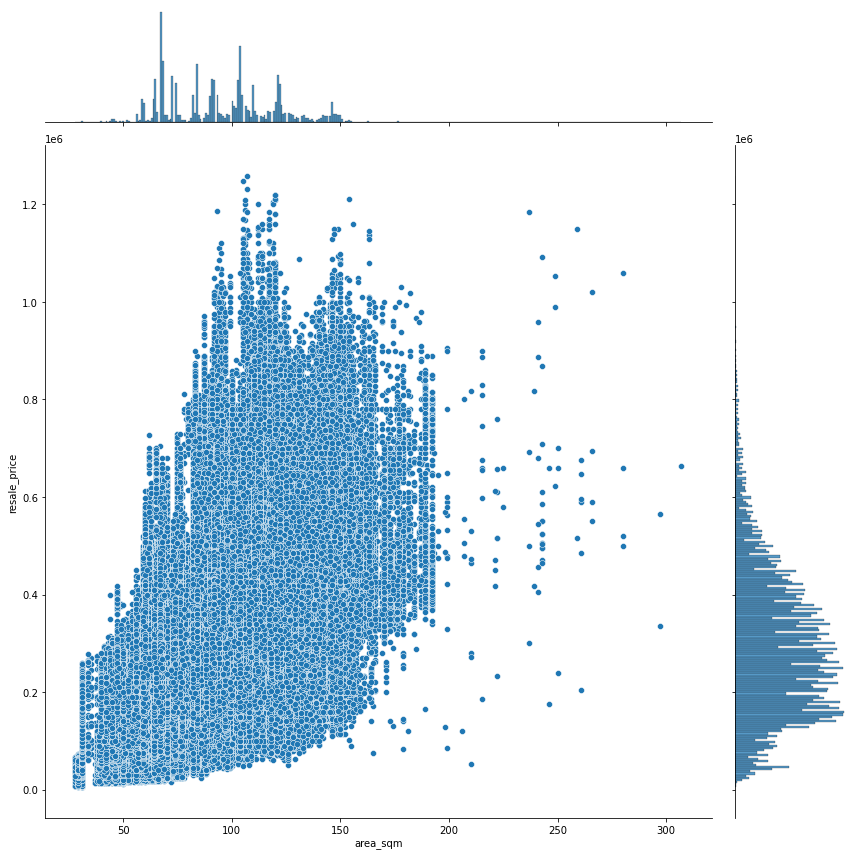

In [106]:
sb.jointplot(data = HDBData, x = "area_sqm", y = "resale_price", height = 12)

In [107]:
HDBData.resale_price.corr(HDBData.area_sqm)

0.618913987882314

In [108]:
# Import the required function from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(HDBData['resale_price'])
X = pd.DataFrame(HDBData['area_sqm'])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

Train Set : (672734, 1) (672734, 1)
Test Set  : (168184, 1) (168184, 1)


In [109]:
linreg.fit(X_train, y_train)

LinearRegression()

In [110]:
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [-46539.8037293]
Coefficients 	: a =  [[3591.0732339]]


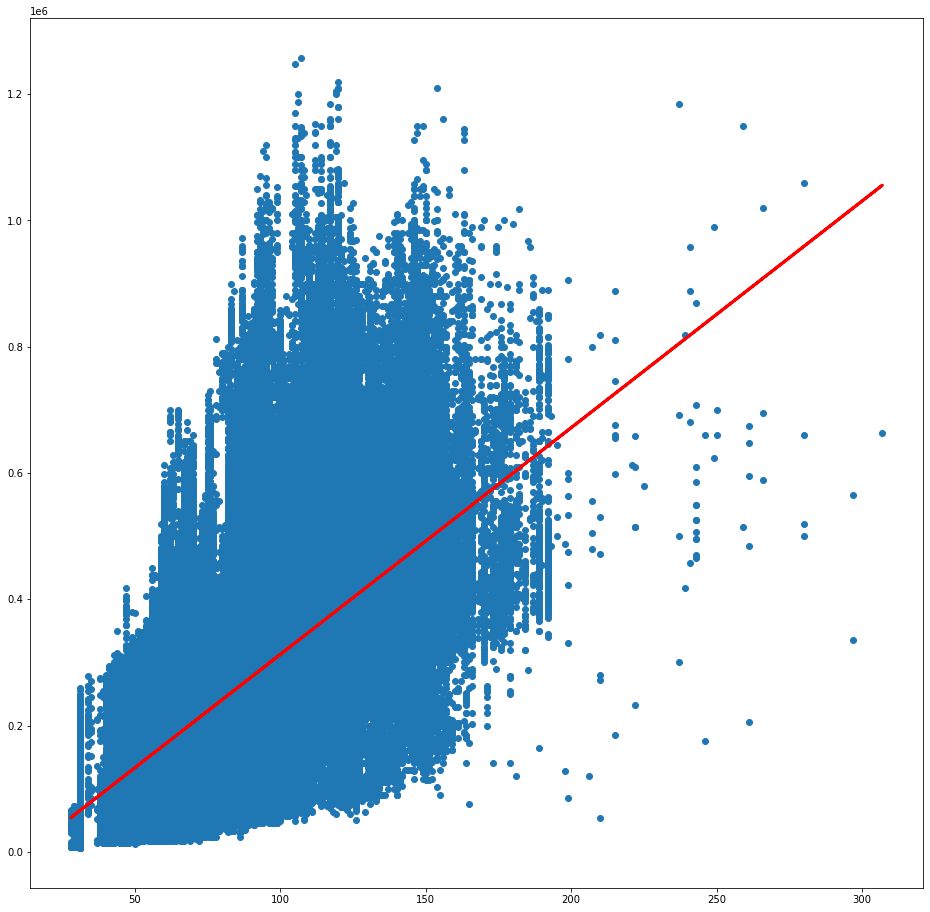

In [111]:
# Formula for the Regression line
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 16))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

In [115]:
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))

Explained Variance (R^2) 	: 0.3835138326293013


In [113]:
# Import the required metric from sklearn
from sklearn.metrics import mean_squared_error

# Predict the response on the train set
y_train_pred = linreg.predict(X_train)

# Compute MSE on the train set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))

Mean Squared Error (MSE) 	: 14039675329.980528


C:\Users\zhenx\AppData\Local\Temp/ipykernel_2364/1041268853.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


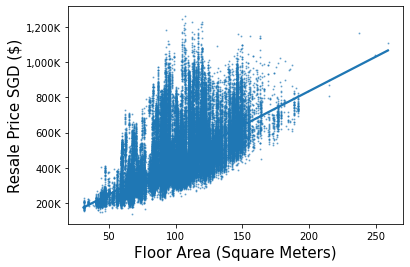

In [114]:
# Floor Area Prices
area = HDBData[HDBData['year'].isin([2016,2017,2018,2019,2020])]
p=sb.regplot(x='area_sqm', y='real_price', data=area, scatter_kws={"s": 1, 'alpha':0.5})
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
p.set_xlabel('Floor Area (Square Meters)', size=15)
plt.show()

## Machine Learning

In [117]:
import numpy as np # linear algebra

#Importing DataSet 
space=HDBData['area_sqm']
price=HDBData['real_price']

HDB1620 = HDBData[HDBData['year'].isin([2016,2017,2018,2019,2020])]
space=HDB1620['area_sqm']
price=HDB1620['real_price']


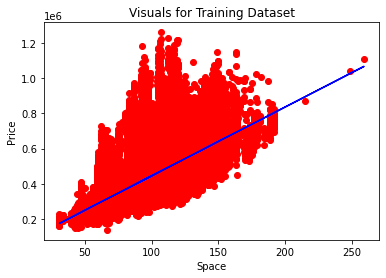

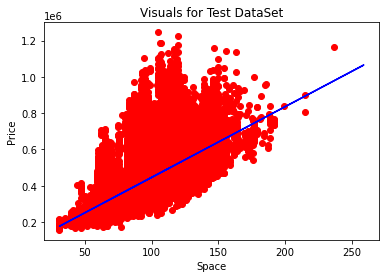

In [118]:
#Importing DataSet 
HDB1620 = HDBData[HDBData['year'].isin([2016,2017,2018,2019,2020])]
space=HDB1620['area_sqm']
price=HDB1620['real_price']

x = np.array(space).reshape(-1, 1)
y = np.array(price)

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=1/3, random_state=0)


#Fitting simple linear regression to the Training Set
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

#Predicting the prices
pred = regressor.predict(xtest)

#Visualizing the training Test Results 
plt.scatter(xtrain, ytrain, color= 'red')
plt.plot(xtrain, regressor.predict(xtrain), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("Space")
plt.ylabel("Price")
plt.show()

#Visualizing the Test Results 
plt.scatter(xtest, ytest, color= 'red')
plt.plot(xtrain, regressor.predict(xtrain), color = 'blue')
plt.title("Visuals for Test DataSet")
plt.xlabel("Space")
plt.ylabel("Price")
plt.show()

In [123]:
HDBData_MRT = pd.read_csv('HDBdata with district_coord_dist_full_withMRTName.csv')
HDBData_MRT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113959 entries, 0 to 113958
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   District             113959 non-null  int64  
 1   month                113959 non-null  object 
 2   town                 113959 non-null  object 
 3   flat_type            113959 non-null  object 
 4   block                113959 non-null  object 
 5   street_name          113959 non-null  object 
 6   storey_range         113959 non-null  object 
 7   floor_area_sqm       113959 non-null  float64
 8   flat_model           113959 non-null  object 
 9   lease_commence_date  113959 non-null  int64  
 10  remaining_lease      113959 non-null  int64  
 11  resale_price         113959 non-null  float64
 12  Price/sqm            113959 non-null  float64
 13  Latitude             113959 non-null  float64
 14  Longitude            113959 non-null  float64
 15  mrtdist          

In [124]:
HDBData_MRT

,District,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Price/sqm,Latitude,Longitude,mrtdist,mrt_name
0,20,1 01 2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61,232000.0,5272.727273,1.375748,103.854640,858.575938,Ang Mo Kio
1,20,1 01 2017,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60,250000.0,3731.343284,1.369525,103.837238,1370.233958,Ang Mo Kio
2,20,1 01 2017,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,262000.0,3910.447761,1.380760,103.835425,896.538505,Bishan
3,20,1 01 2017,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62,265000.0,3897.058824,1.366213,103.857175,942.352562,Ang Mo Kio
4,20,1 01 2017,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,265000.0,3955.223881,1.380987,103.835076,856.601041,Bishan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113954,27,1 11 2021,YISHUN,EXECUTIVE,792,YISHUN RING RD,10 TO 12,144.0,Apartment,1987,65,690000.0,4791.666667,1.420576,103.832406,360.689410,Khatib
113955,27,1 11 2021,YISHUN,EXECUTIVE,611,YISHUN ST 61,10 TO 12,142.0,Apartment,1987,65,680000.0,4788.732394,1.420169,103.835955,453.144959,Khatib
113956,27,1 11 2021,YISHUN,EXECUTIVE,614,YISHUN ST 61,01 TO 03,142.0,Apartment,1987,65,632000.0,4450.704225,1.419741,103.836178,441.718437,Khatib
113957,27,1 11 2021,YISHUN,EXECUTIVE,837,YISHUN ST 81,01 TO 03,145.0,Maisonette,1988,66,755000.0,5206.896552,1.414324,103.838877,738.524941,Khatib


In [125]:
HDBData_MRT['month'] = pd.to_datetime(HDBData_MRT['month']) # to datetime
HDBData_MRT.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113959 entries, 0 to 113958
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   District             113959 non-null  int64         
 1   month                113959 non-null  datetime64[ns]
 2   town                 113959 non-null  object        
 3   flat_type            113959 non-null  object        
 4   block                113959 non-null  object        
 5   street_name          113959 non-null  object        
 6   storey_range         113959 non-null  object        
 7   floor_area_sqm       113959 non-null  float64       
 8   flat_model           113959 non-null  object        
 9   lease_commence_date  113959 non-null  int64         
 10  remaining_lease      113959 non-null  int64         
 11  resale_price         113959 non-null  float64       
 12  Price/sqm            113959 non-null  float64       
 13  Latitude      

In [126]:
HDBData_MRT[~HDBData_MRT.isnull().any(axis=1)]['month'].dt.year.unique()

array([2017, 2018, 2019, 2020, 2021], dtype=int64)

In [127]:
HDBData_MRT['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

In [128]:
HDBData_MRT['flat_model'].value_counts()

Model A                   37413
Improved                  28511
New Generation            14763
Premium Apartment         13026
Apartment                  4582
Simplified                 4484
Maisonette                 3442
Standard                   3236
DBSS                       2166
Model A2                   1352
Adjoined flat               214
Model A-Maisonette          204
Type S1                     204
Type S2                     118
Terrace                      72
Premium Apartment Loft       72
Multi Generation             58
Improved-Maisonette          18
2-room                       13
Premium Maisonette           11
Name: flat_model, dtype: int64

In [129]:
# Rename flat model duplicates
replace_values = {'MULTI GENERATION':'Multi Generation', 'Improved-Maisonette':'Executive Maisonette', 'Premium Maisonette':'Executive Maisonette', '2-ROOM':'2-room', 'Model A-Maisonette':'Maisonette', 'Premium Apartment Loft':'Premium Apartment', 'Type S1':'Type S1S2', 'Type S2':'Type S1S2'}

HDBData_MRT = HDBData_MRT.replace({'flat_model': replace_values})

HDBData_MRT['flat_model'].value_counts()

Model A                 37413
Improved                28511
New Generation          14763
Premium Apartment       13098
Apartment                4582
Simplified               4484
Maisonette               3646
Standard                 3236
DBSS                     2166
Model A2                 1352
Type S1S2                 322
Adjoined flat             214
Terrace                    72
Multi Generation           58
Executive Maisonette       29
2-room                     13
Name: flat_model, dtype: int64

In [130]:
HDBData_MRT['year'] = pd.DatetimeIndex(HDBData_MRT['month']).year # extract out year
HDBData_MRT.head()

,District,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Price/sqm,Latitude,Longitude,mrtdist,mrt_name,year
0,20,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61,232000.0,5272.727273,1.375748,103.854640,858.575938,Ang Mo Kio,2017
1,20,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60,250000.0,3731.343284,1.369525,103.837238,1370.233958,Ang Mo Kio,2017
2,20,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,262000.0,3910.447761,1.380760,103.835425,896.538505,Bishan,2017
3,20,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62,265000.0,3897.058824,1.366213,103.857175,942.352562,Ang Mo Kio,2017
4,20,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,265000.0,3955.223881,1.380987,103.835076,856.601041,Bishan,2017


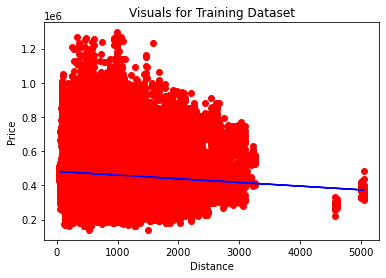

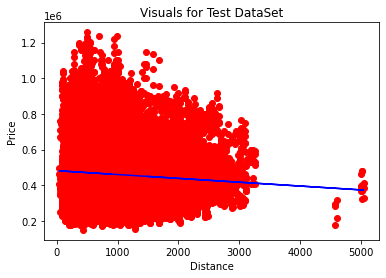

In [131]:
#Importing DataSet 
distance=HDBData_MRT['mrtdist']
price=HDBData_MRT['resale_price']


x = np.array(distance).reshape(-1, 1)
y = np.array(price)

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=1/3, random_state=0)


#Fitting simple linear regression to the Training Set
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

#Predicting the prices
pred = regressor.predict(xtest)

#Visualizing the training Test Results 
plt.scatter(xtrain, ytrain, color= 'red')
plt.plot(xtrain, regressor.predict(xtrain), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("Distance")
plt.ylabel("Price")
plt.show()

#Visualizing the Test Results 
plt.scatter(xtest, ytest, color= 'red')
plt.plot(xtrain, regressor.predict(xtrain), color = 'blue')
plt.title("Visuals for Test DataSet")
plt.xlabel("Distance")
plt.ylabel("Price")
plt.show()


In [132]:
HDB_4Room = HDBData[HDBData['flat_type'].isin(['4 ROOM'])]
HDB_4Room = HDB_4Room[HDBData['year'].isin([2016,2017,2018,2019,2020])]

HDB_4Room = HDB_4Room[['town', 'storey_range', 'area_sqm', 'lease_rem', 'price_cpi_adj']]

HDB_4Room.head()




C:\Users\zhenx\AppData\Local\Temp/ipykernel_2364/3034650879.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  HDB_4Room = HDB_4Room[HDBData['year'].isin([2016,2017,2018,2019,2020])]


,town,storey_range,area_sqm,lease_rem,price_cpi_adj
726877,ANG MO KIO,01 TO 03,98.0,61,429936.1388
726878,ANG MO KIO,07 TO 09,92.0,63,445665.5097
726879,ANG MO KIO,01 TO 03,91.0,63,459297.6312
726880,ANG MO KIO,07 TO 09,92.0,62,480270.1257
726881,ANG MO KIO,10 TO 12,97.0,60,487610.4988


In [133]:
HDB_4Room['storey_range'] = HDB_4Room['storey_range'].str[-2:].astype('int')
HDB_4Room = HDB_4Room.rename(columns={'storey_range':'storey'})
HDB_4Room.head()

,town,storey,area_sqm,lease_rem,price_cpi_adj
726877,ANG MO KIO,3,98.0,61,429936.1388
726878,ANG MO KIO,9,92.0,63,445665.5097
726879,ANG MO KIO,3,91.0,63,459297.6312
726880,ANG MO KIO,9,92.0,62,480270.1257
726881,ANG MO KIO,12,97.0,60,487610.4988


In [134]:
HDB_4Room.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44302 entries, 726877 to 833787
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   town           44302 non-null  object 
 1   storey         44302 non-null  int32  
 2   area_sqm       44302 non-null  float64
 3   lease_rem      44302 non-null  int64  
 4   price_cpi_adj  44302 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 1.9+ MB


In [135]:
HDB_4Room.isna().sum()

town             0
storey           0
area_sqm         0
lease_rem        0
price_cpi_adj    0
dtype: int64

In [136]:
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['ANG MO KIO','CENTRAL AREA','BISHAN','MARINE PARADE','TOA PAYOH'], 'CENTRAL'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['SEMBAWANG','SENGKANG','WOODLANDS','YISHUN'], 'NORTH'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['BUKIT MERAH','BUKIT TIMAH','QUEENSTOWN'], 'SOUTH'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['BEDOK','GEYLANG','HOUGANG','KALLANG/WHAMPOA','PASIR RIS','PUNGGOL','SERANGOON','TAMPINES'], 'EAST'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','CLEMENTI','JURONG EAST','JURONG WEST'], 'WEST'))
HDB_4Room.head()

,town,storey,area_sqm,lease_rem,price_cpi_adj
726877,CENTRAL,3,98.0,61,429936.1388
726878,CENTRAL,9,92.0,63,445665.5097
726879,CENTRAL,3,91.0,63,459297.6312
726880,CENTRAL,9,92.0,62,480270.1257
726881,CENTRAL,12,97.0,60,487610.4988


In [137]:
X = HDB_4Room.iloc[:,:-1].values
y = HDB_4Room.iloc[:,-1].values
HDB_4Room['town'].unique()

array(['CENTRAL', 'EAST', 'WEST', 'SOUTH', 'NORTH'], dtype=object)

In [138]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
X[1,:]

array([1.0, 0.0, 0.0, 0.0, 0.0, 9, 92.0, 63], dtype=object)

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [140]:
from sklearn.ensemble import RandomForestRegressor
forest_r = RandomForestRegressor(n_estimators = 9)
forest_r.fit(X_train, y_train)
forest_ypred = forest_r.predict(X_test)
forest_acc = r2_score(y_test,forest_ypred)
forest_acc

0.7736491402735545

In [141]:
# We know that after One Hot Encoding, the value of Central, East, North, South, and West is one at column 1,2,3,4, and 5, respectively (following alphabetical order).
area = ['North','South','East','West', 'Central']
pred_price_north = forest_r.predict([[0.0, 0.0, 1.0, 0.0, 0.0, 10, 95.0, 75]])[0]
pred_price_south = forest_r.predict([[0.0, 0.0, 0.0, 1.0, 0.0, 10, 95.0, 75]])[0]
pred_price_east = forest_r.predict([[0.0, 1.0, 0.0, 0.0, 0.0, 10, 95.0, 75]])[0]
pred_price_west = forest_r.predict([[0.0, 0.0, 0.0, 0.0, 1.0, 10, 95.0, 75]])[0]
pred_price_central = forest_r.predict([[1.0, 0.0, 0.0, 0.0, 0.0, 10, 95.0, 75]])[0]
resale_price = [pred_price_north,pred_price_south,pred_price_east,pred_price_west,pred_price_central]
predict_df = pd.DataFrame(list(zip(area, resale_price)),
              columns=['Area','Predicted HDB price (SGD)'])
predict_df.round()

,Area,Predicted HDB price (SGD)
0,North,344689.0
1,South,648004.0
2,East,580332.0
3,West,379337.0
4,Central,551955.0


In [142]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor


HDB_3Room = HDBData[HDBData['flat_type'].isin(['3 ROOM'])]
HDB_3Room = HDB_3Room[HDB_3Room['year'].isin([2016,2017,2018,2019,2020])]
HDB_3Room = HDB_3Room[['town', 'storey_range', 'area_sqm', 'lease_rem', 'price_cpi_adj']]

HDB_3Room['storey_range'] = HDB_3Room['storey_range'].str[-2:].astype('int')
HDB_3Room = HDB_3Room.rename(columns={'storey_range':'storey'})

HDB_3Room = HDB_3Room.replace(dict.fromkeys(['ANG MO KIO','CENTRAL AREA','BISHAN','MARINE PARADE','TOA PAYOH'], 'CENTRAL'))
HDB_3Room = HDB_3Room.replace(dict.fromkeys(['SEMBAWANG','SENGKANG','WOODLANDS','YISHUN'], 'NORTH'))
HDB_3Room = HDB_3Room.replace(dict.fromkeys(['BUKIT MERAH','BUKIT TIMAH','QUEENSTOWN'], 'SOUTH'))
HDB_3Room = HDB_3Room.replace(dict.fromkeys(['BEDOK','GEYLANG','HOUGANG','KALLANG/WHAMPOA','PASIR RIS','PUNGGOL','SERANGOON','TAMPINES'], 'EAST'))
HDB_3Room = HDB_3Room.replace(dict.fromkeys(['BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','CLEMENTI','JURONG EAST','JURONG WEST'], 'WEST'))

HDB_3Room.info()
HDB_3Room.isna().sum()
HDB_3Room.head()

X = HDB_3Room.iloc[:,:-1].values
y = HDB_3Room.iloc[:,-1].values
HDB_3Room['town'].unique()

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
X[1,:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
forest_r = RandomForestRegressor(n_estimators = 9)
forest_r.fit(X_train, y_train)
forest_ypred = forest_r.predict(X_test)
forest_acc = r2_score(y_test,forest_ypred)

# We know that after One Hot Encoding, the value of Central, East, North, South, and West is one at column 1,2,3,4, and 5, respectively (following alphabetical order).
area = ['North','South','East','West', 'Central']
pred_price_north = forest_r.predict([[0.0, 0.0, 1.0, 0.0, 0.0, 10, 95.0, 75]])[0]
pred_price_south = forest_r.predict([[0.0, 0.0, 0.0, 1.0, 0.0, 10, 95.0, 75]])[0]
pred_price_east = forest_r.predict([[0.0, 1.0, 0.0, 0.0, 0.0, 10, 95.0, 75]])[0]
pred_price_west = forest_r.predict([[0.0, 0.0, 0.0, 0.0, 1.0, 10, 95.0, 75]])[0]
pred_price_central = forest_r.predict([[1.0, 0.0, 0.0, 0.0, 0.0, 10, 95.0, 75]])[0]
resale_price = [pred_price_north,pred_price_south,pred_price_east,pred_price_west,pred_price_central]
predict_df = pd.DataFrame(list(zip(area, resale_price)),
              columns=['Area','Predicted HDB price (SGD)'])
predict_df.round()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26014 entries, 726836 to 833805
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   town           26014 non-null  object 
 1   storey         26014 non-null  int32  
 2   area_sqm       26014 non-null  float64
 3   lease_rem      26014 non-null  int64  
 4   price_cpi_adj  26014 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 1.1+ MB


,Area,Predicted HDB price (SGD)
0,North,419998.0
1,South,468869.0
2,East,475101.0
3,West,434276.0
4,Central,461542.0


In [143]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor


HDB_4Room = HDBData[HDBData['flat_type'].isin(['4 ROOM'])]
HDB_4Room = HDB_4Room[HDB_4Room['year'].isin([2016,2017,2018,2019,2020])]
HDB_4Room = HDB_4Room[['town', 'storey_range', 'area_sqm', 'lease_rem', 'price_cpi_adj']]

HDB_4Room['storey_range'] = HDB_4Room['storey_range'].str[-2:].astype('int')
HDB_4Room = HDB_4Room.rename(columns={'storey_range':'storey'})

HDB_4Room = HDB_4Room.replace(dict.fromkeys(['ANG MO KIO','CENTRAL AREA','BISHAN','MARINE PARADE','TOA PAYOH'], 'CENTRAL'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['SEMBAWANG','SENGKANG','WOODLANDS','YISHUN'], 'NORTH'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['BUKIT MERAH','BUKIT TIMAH','QUEENSTOWN'], 'SOUTH'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['BEDOK','GEYLANG','HOUGANG','KALLANG/WHAMPOA','PASIR RIS','PUNGGOL','SERANGOON','TAMPINES'], 'EAST'))
HDB_4Room = HDB_4Room.replace(dict.fromkeys(['BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','CLEMENTI','JURONG EAST','JURONG WEST'], 'WEST'))

HDB_4Room.info()
HDB_4Room.isna().sum()
HDB_4Room.head()

X = HDB_4Room.iloc[:,:-1].values
y = HDB_4Room.iloc[:,-1].values
HDB_4Room['town'].unique()

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
X[1,:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
forest_r = RandomForestRegressor(n_estimators = 9)
forest_r.fit(X_train, y_train)
forest_ypred = forest_r.predict(X_test)
forest_acc = r2_score(y_test,forest_ypred)

# We know that after One Hot Encoding, the value of Central, East, North, South, and West is one at column 1,2,3,4, and 5, respectively (following alphabetical order).
area = ['North','South','East','West', 'Central']
pred_price_north = forest_r.predict([[0.0, 0.0, 1.0, 0.0, 0.0, 10, 95.0, 75]])[0]
pred_price_south = forest_r.predict([[0.0, 0.0, 0.0, 1.0, 0.0, 10, 95.0, 75]])[0]
pred_price_east = forest_r.predict([[0.0, 1.0, 0.0, 0.0, 0.0, 10, 95.0, 75]])[0]
pred_price_west = forest_r.predict([[0.0, 0.0, 0.0, 0.0, 1.0, 10, 95.0, 75]])[0]
pred_price_central = forest_r.predict([[1.0, 0.0, 0.0, 0.0, 0.0, 10, 95.0, 75]])[0]
resale_price = [pred_price_north,pred_price_south,pred_price_east,pred_price_west,pred_price_central]
predict_df = pd.DataFrame(list(zip(area, resale_price)),
              columns=['Area','Predicted HDB price (SGD)'])
predict_df.round()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44302 entries, 726877 to 833787
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   town           44302 non-null  object 
 1   storey         44302 non-null  int32  
 2   area_sqm       44302 non-null  float64
 3   lease_rem      44302 non-null  int64  
 4   price_cpi_adj  44302 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 1.9+ MB


,Area,Predicted HDB price (SGD)
0,North,359154.0
1,South,651922.0
2,East,514765.0
3,West,428436.0
4,Central,530182.0


## Ridge Regression 

In [146]:
from sklearn.linear_model import Ridge
ridge_r = Ridge()
ridge_r.fit(xtrain, ytrain)
ridge_ypred = ridge_r.predict(xtest)
ridge_acc = r2_score(ytest,ridge_ypred)
ridge_acc

0.00780797471444461

## Decision Regression

In [149]:
from sklearn.tree import DecisionTreeRegressor
tree_r = DecisionTreeRegressor()
tree_r.fit(xtrain, ytrain)
tree_ypred = tree_r.predict(xtest)
tree_acc = r2_score(ytest,tree_ypred)
tree_acc

0.7645746368527404

## Lasso Regression

In [148]:
from sklearn.linear_model import Lasso
lasso_r = Lasso(max_iter=100000)
lasso_r.fit(xtrain, ytrain)
lasso_ypred = lasso_r.predict(xtest)
lasso_acc = r2_score(ytest,lasso_ypred)
lasso_acc

0.007807974596631073